# Projet IMA201 : Fusion d'expositions

Le travail effectué ci-dessous est basé sur l'article ["Exposure Fusion"](https://perso.telecom-paristech.fr/gousseau/IMA201/proj2018/exposure_fusion.pdf) (Fusion d'expositions). 

Il s'agit de combiner différents clichés d'une même scène ayant chacun un temps d'ouverture différent, afin de créer une image n'ayant pas de région saturée ou sous-exposée. Il s'agit en bref d'**extraire les meilleures régions de chacune des images et de les combiner**. Cette méthode est différente de la méthode HDR en cela que l'on travaille directement avec des images affichables, et ne nécessitant pas de _tone mapping_ pour réajuster la dynamique.

Nous allons, comme dans l'article, procéder en **deux temps**. Tout d'abord, nous allons implémenter une **méthode dite naïve**, puis une **méthode plus sophistiquée à base de pyramides laplaciennes et gaussiennes**.

On commence par effectuer une série d'importations de bibliothèques Python et on se place dans le bon répertoire pour sélectionner les images.

In [1]:
import cv2
import numpy as np
from time import time
from matplotlib import pyplot as plt
from PIL import Image
from scipy.ndimage.filters import *
from scipy.optimize import *

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
import statsmodels.api as sm

import glob
import os
os.chdir(r'C:\Users\theor\OneDrive\Documents\Travaux\Télécom ParisTech ~ 2A\IMA\IMA201\Projet')

On extrait ensuite les images du répertoire afin de les encapsuler dans des array numpy. On définit également l'index qui donne le nombre de couches dans la construction des pyramides pour la seconde méthode.

In [2]:
debut = time()
# Images
name = 'grandcanal'
index = 5 # pyramid level

# BGR order

img = []

for fname in glob.glob(name+'*.jpg'):
    img_k = cv2.imread(fname)
    
    img_k = img_k[-int(2**index*np.floor(len(img_k)/2**index)):,-int(2**index*np.floor(len(img_k[0])/2**index)):,] 
    # Cropping the picture to get a multiple of 2**index pixels
    
    b,g,r = cv2.split(img_k)       # get b,g,r
    img_k = cv2.merge([r,g,b])     # convert BGR to RGB
    img.append(img_k)

img = np.array(img)

# Careful: img[0] contains image_1.jpg, and so on
img_norm = img/255

## Méthode Naïve 

### Contraste

In [3]:
eps=0.0001
# We convert the normalised images in grayscale and then apply a Laplace filter
C = np.array([np.abs(laplace(cv2.cvtColor(img[i],cv2.COLOR_RGB2GRAY)/255)) for i in range(len(img))])+eps

#plt.imshow(C[4],cmap='gray') # display
#plt.show()

### Saturation

In [4]:
S = np.array([np.std(img_norm[i],axis=2) for i in range(len(img_norm))])+eps

### Bonne exposition

In [5]:
std = 0.2 # standard deviation

img_blue_gauss = np.array([np.exp(-(img_norm[i,:,:,0]-0.5)**2/(2*(std**2))) for i in range (len(img_norm))])
img_green_gauss = np.array([np.exp(-(img_norm[i,:,:,1]-0.5)**2/(2*(std**2))) for i in range (len(img_norm))])
img_red_gauss = np.array([np.exp(-(img_norm[i,:,:,2]-0.5)**2/(2*(std**2))) for i in range (len(img_norm))])

E = img_blue_gauss*img_green_gauss*img_red_gauss+eps

### Carte des poids puis résultante finale

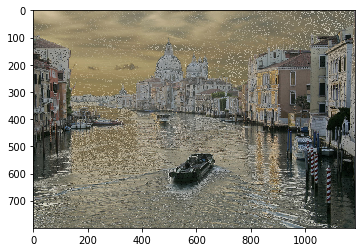

Temps de la méthode naïve :  3.108978509902954


In [6]:
W = C*S*E # weights

# Fusion

W_normalised = (np.sum(W,axis=0)**(-1))*W # normalised weights
W_BGR = np.expand_dims(W_normalised, 3) # for BGR
W_BGR = np.repeat(W_BGR, 3, axis=3) # same weights for each channel

R = np.sum(W_BGR*img_norm, axis=0)
if R.max()>1:
    R/=R.max() 
# resulting image for naive method
plt.imsave(name + "_naive.png", R)
plt.imshow(R)
plt.show()
fin1 = time()
print("Temps de la méthode naïve : ", fin1 - debut)

## Amélioration de la méthode naïve

On cherche ensuite à réaligner les histogrammes pour pouvoir avoir un meilleur résultat avec cette même méthode

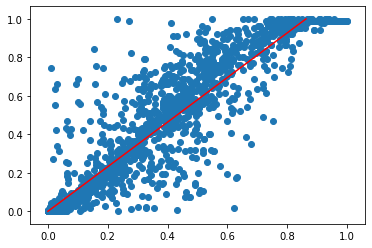

In [7]:
nnorm=img_norm.copy()
for i in range(len(nnorm)):
    nnorm[i] /= np.max(nnorm[i])

p1 = 3 # empirically found 

X = nnorm[1]**p1
y = nnorm[0]
X = X.reshape(-1)
y = y.reshape(-1)
plt.scatter(nnorm[0][::20,::20,0],nnorm[1][::20,::20,0]**p1)

X = sm.add_constant(X)
model = sm.OLS(X,y)
results = model.fit()

slope1 = results.params[0][1]

x = np.linspace(0,1/slope1,100)
y = slope1*x
plt.plot(x, y, c ='red')
plt.show()

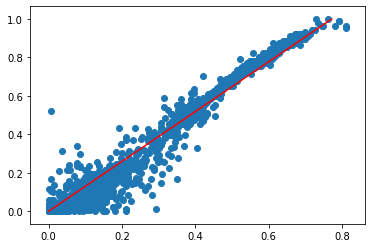

In [8]:
p2 = 3 # empirically found 
X = nnorm[0]**p2
y = nnorm[2]
X = X.reshape(-1)
y = y.reshape(-1)
plt.scatter(nnorm[2][::20,::20,0],nnorm[0][::20,::20,0]**p2)

X = sm.add_constant(X)
model = sm.OLS(X,y)
results = model.fit()

slope2 = results.params[0][1] # fitting the curves to determine a (y = ax^p)

x = np.linspace(0,1/slope2,100)
y = slope2*x
plt.plot(x, y, c ='red')
plt.show()

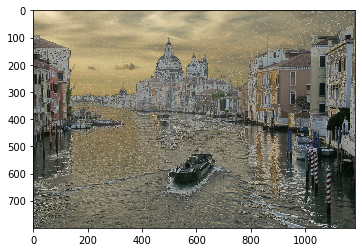

Temps de la naïve améliorée :  8.315611362457275


In [9]:
img_norm_new = np.array([img_norm[0],slope1*img_norm[1],slope2*img_norm[2]])
img_new = 255*img_norm_new

eps=0.0001
C = np.array([np.abs(laplace(cv2.cvtColor(img_new[i].astype('float32'),cv2.COLOR_RGB2GRAY)/255)) for i in range(len(img_new))])+eps
S = np.array([np.std(img_norm_new[i],axis=2) for i in range(len(img_norm_new))])+eps
std = 0.2 # standard deviation
img_blue_gauss = np.array([np.exp(-(img_norm_new[i,:,:,0]-0.5)**2/(2*(std**2))) for i in range (len(img_norm_new))])
img_green_gauss = np.array([np.exp(-(img_norm_new[i,:,:,1]-0.5)**2/(2*(std**2))) for i in range (len(img_norm_new))])
img_red_gauss = np.array([np.exp(-(img_norm_new[i,:,:,2]-0.5)**2/(2*(std**2))) for i in range (len(img_norm_new))])
E = img_blue_gauss*img_green_gauss*img_red_gauss+eps

W = C*S*E 

W_normalised = (np.sum(W,axis=0)**(-1))*W # normalised weights
W_BGR = np.expand_dims(W_normalised, 3) # for BGR
W_BGR = np.repeat(W_BGR, 3, axis=3) # same weights for each channel

R_new = np.sum(W_BGR*img_norm_new, axis=0) # resulting image for naive method
R_new/=np.max(R_new)
plt.imsave(name + "_naive2.png", R_new)
plt.imshow(R_new)
plt.show()
fin2 = time()
print("Temps de la naïve améliorée : ", fin2-debut)

## Méthode utilisant les pyramides gaussiennes et laplaciennes

### Implémentation des pyramides 

$$ L\{R\}_{ij}^l = \sum_{k=1}^N G\{\hat{W}\}_{ij,k}^l L\{I\}_{ij,k}^l $$

In [10]:
def gaussian_pyramid(image, index):
    layer = image.copy()
    gp = [layer]

    for i in range(index):
        layer = cv2.pyrDown(layer)
        gp.append(layer)

    return gp

def laplacian_pyramid(image, index):
    gp = gaussian_pyramid(image, index+1)

    lp = [gp[index]]

    for i in range(index, 0, -1):
        GE = cv2.pyrUp(gp[i])
        layer = cv2.subtract(gp[i-1],GE)
        lp.append(layer)
    lp.reverse()
    return lp

### Création des pyramides pour les images observées 

In [11]:
L_I = []
img_norm = img_norm_new

for image in img_norm:
    lp = laplacian_pyramid(image, index)
    L_I.append(lp)

# Gaussian Pyramid for weight maps
G_W = []

for weight_map in W_BGR:
    # generate Gaussian Pyramid
    gp = gaussian_pyramid(weight_map, index)

    G_W.append(gp)

G_W = np.array(G_W)
L_R = np.sum(G_W * L_I, axis=0)

### Création de l'image finale par aplatissement de la pyramide

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Temps de la méthode pyramidale :  4.011627435684204


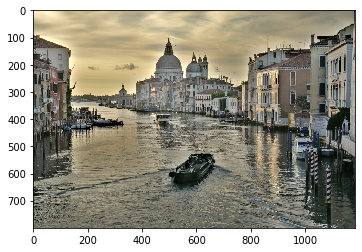

In [12]:
laplacian_pyramid = L_R

reconstructed_image = laplacian_pyramid[-1]

for i in range(index-1, -1, -1):
    size = (reconstructed_image[i].shape[1], reconstructed_image[i].shape[0])
    reconstructed_image = cv2.pyrUp(reconstructed_image)#, dstsize=size)
    reconstructed_image = cv2.add(reconstructed_image, laplacian_pyramid[i])

plt.imshow(reconstructed_image)
r, g, b = cv2.split(reconstructed_image)    # get r, g, b
reconstructed_image = cv2.merge([b,g,r])    # convert RGB to BGR
cv2.imwrite(name + "_finale2.png", 255*reconstructed_image)
fin3 = time()
print("Temps de la méthode pyramidale : ", fin3 - debut - fin2 + fin1)


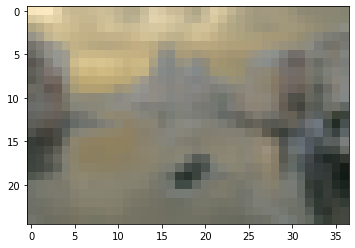

In [13]:
plt.imshow(laplacian_pyramid[-1])